In [0]:
import torch 
from torchvision import transforms , models 
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

In [0]:
device = ("cuda" if torch.cuda.is_available() else "cpu")


model = models.vgg19(pretrained=True).features

for p in model.parameters():
    p.requires_grad = False
model.to(device)

In [0]:
layers = {
    '0' : 'conv1_1',
    '5' : 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'
    }


def model_activations(image):
  x = image.unsqueeze(0)
  features = {}

  for name, layer in model._modules.items():
    #print(name, layer)
    x = layer(x)
    if name in layers:
      features[layers[name]] = x

  return features
      

In [0]:
def convert_it_back(image):
  x = image.to('cpu').clone().detach().numpy().squeeze()
  x = x.transpose(1,2,0)
  x = x*np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  return x

In [0]:
def gram_matrix(features):
  _, d, h, w = features.shape
  features = features.view(d, h*w)
  gram = torch.mm(features, features.t())
  return gram

In [0]:
transform = transforms.Compose([
                                transforms.Resize(300),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [0]:
content = Image.open("content.jpg").convert("RGB")
content = transform(content).to(device)

style = Image.open("style.jpg").convert("RGB")
style = transform(style).to(device)

target = content.clone().requires_grad_(True).to(device)

In [0]:
content_features = model_activations(content)
style_features = model_activations(style)

style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

In [0]:
style_wt_meas = {"conv1_1" : 1.0, 
                 "conv2_1" : 0.8,
                 "conv3_1" : 0.4,
                 "conv4_1" : 0.2,
                 "conv5_1" : 0.1,
                 "conv4_2" : 0}

content_wt = 100
style_wt = 1e8

print_after = 500

epochs = 4000
optimizer = torch.optim.Adam([target],lr=0.007)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


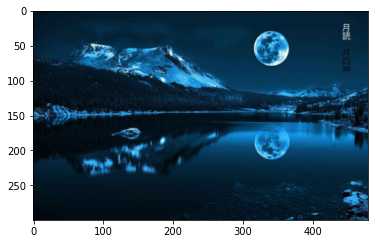

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


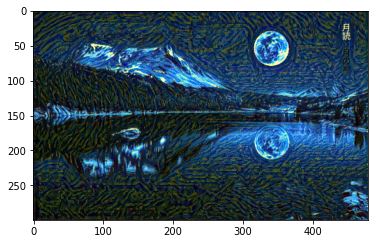

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


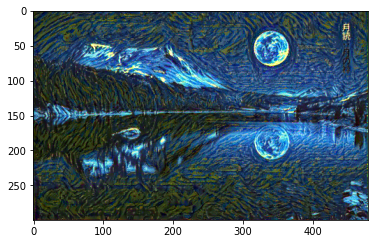

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


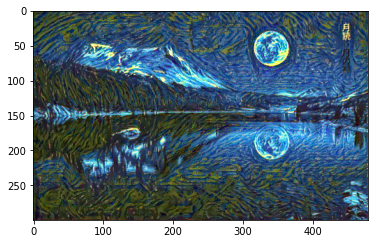

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


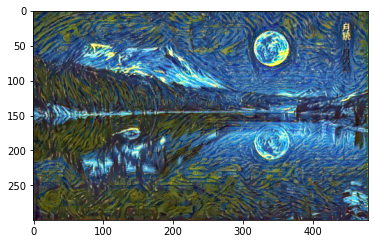

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


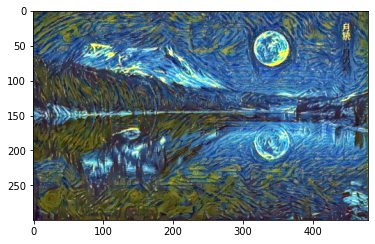

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


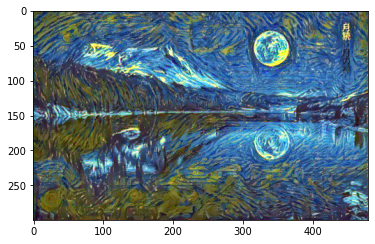

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


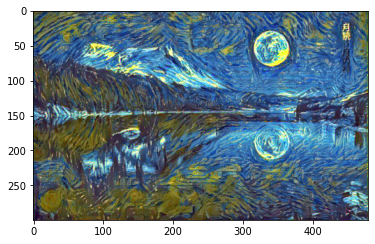

In [0]:
for i in range(epochs):
  target_features = model_activations(target)
  content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)
  
  style_loss = 0
  target_grams = {layer:gram_matrix(target_features[layer]) for layer in target_features}

  for layer in style_grams:
    style_gram = style_grams[layer]
    target_gram = target_grams[layer]
    d, wh = target_gram.shape
    style_loss += (style_wt_meas[layer]*torch.mean((target_gram-style_gram)**2))/d*wh


  total_loss = content_wt*content_loss + style_wt*style_loss 

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if i%print_after == 0:
        plt.imshow(convert_it_back(target),label="Epoch "+str(i))
        plt.show()
        #plt.imsave(str(i)+'.png',convert_it_back(target),format='png')